# Dataset exploration and preprocessing

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Exploring the dataset

In [25]:
path_train_data = 'labeledTrainData.tsv'

df = pd.read_csv(path_train_data, delimiter = '\t')

In [26]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [31]:
#Size of the training dataset

df.shape

(25000, 3)

In [27]:
#Exemple d'une critique de film

print('Exemple d\'une critique de film :\n')
print(df['review'][0])
sent = df['sentiment'][0]
print(f'\nlabel de cette critique :{sent} \n\nRappel : 1 = positif, 0 = négatif')

Exemple d'une critique de film :

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual fea

In [24]:
print(len(df['review'][0]))

2302


In [35]:
df_copy = df.copy()

df_copy['lenght'] = df['review']

In [38]:
df_copy['lenght'] = df_copy['lenght'].apply(lambda x : len(x))
df_copy.head()

,id,sentiment,review,lenght
0,5814_8,1,With all this stuff going down at the moment w...,2302
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2449
3,3630_4,0,It must be assumed that those who praised this...,2245
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231


In [62]:
#uniformisation des légendes matplotblib

font_title = {'color':  'steelblue',
        'weight': 'normal',
        'size': 16}

font_label = {'color':  'darkslategray',
        'weight': 'normal',
        'size': 12}

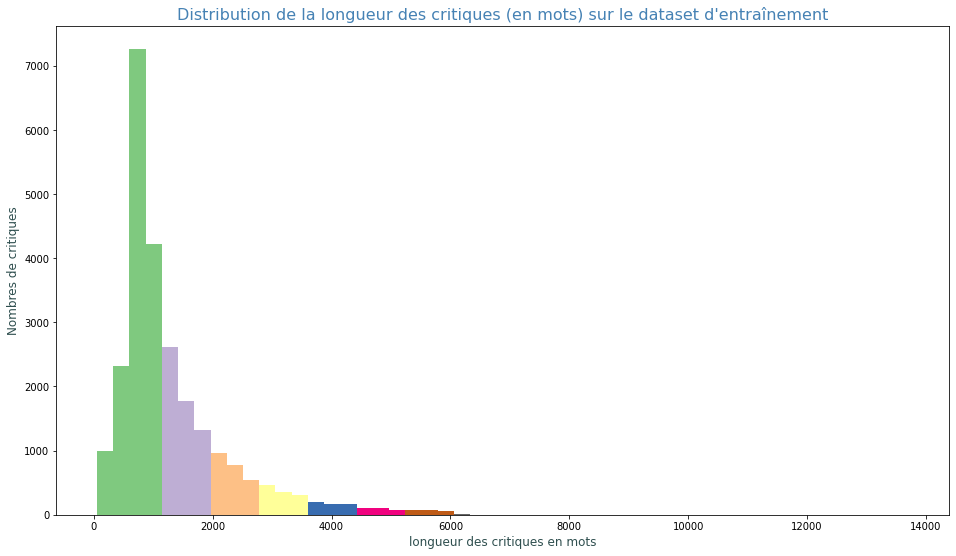

In [64]:
fig = plt.figure(1, figsize=(16, 9))

cm = plt.cm.get_cmap('Accent')

n, bins, patches = plt.hist(df_copy['lenght'],bins = 50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])


for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/25)) 
plt.title('Distribution de la longueur des critiques (en mots) sur le dataset d\'entraînement', 
          fontdict = font_title)

plt.xlabel('longueur des critiques en mots', fontdict = font_label)
plt.ylabel('Nombres de critiques', fontdict = font_label)

plt.show()



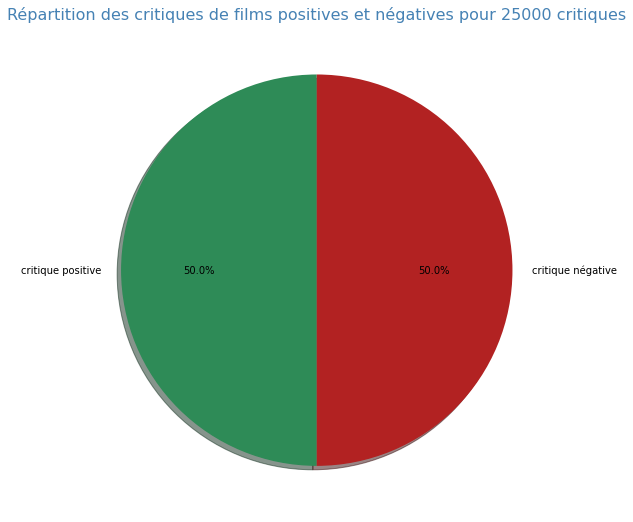

In [74]:
#Répartition des labels 
nb_donnees = 25000
x = [np.sum(df['sentiment']),nb_donnees - np.sum(df['sentiment'])]
labels = ['critique positive', 'critique négative' ]
colors = ['seagreen', 'firebrick']
plt.figure(1, figsize = (16,9))

plt.pie(x, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = colors)
plt.title(f'Répartition des critiques de films positives et négatives pour {nb_donnees} critiques', fontdict = font_title)
plt.show()

Text(0, 0.5, 'Densité')

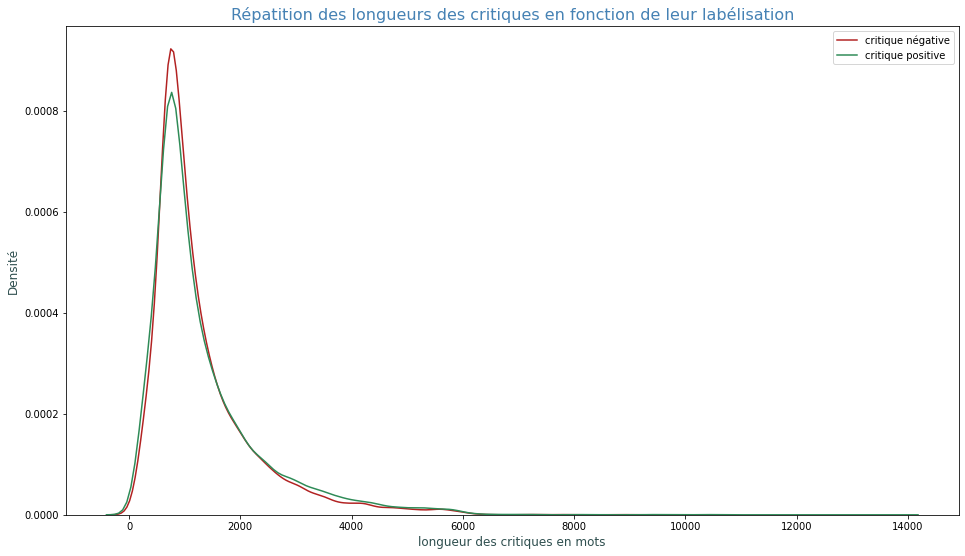

In [79]:
plt.figure(1, figsize=(16,9))

sns.kdeplot(df_copy[df_copy['sentiment']==0]['lenght'],color='firebrick')
sns.kdeplot(df_copy[df_copy['sentiment']==1]['lenght'],color='seagreen')
plt.legend(['critique négative','critique positive'])
plt.title('Répatition des longueurs des critiques en fonction de leur labélisation', fontdict = font_title)
plt.xlabel('longueur des critiques en mots', fontdict = font_label)
plt.ylabel('Densité', fontdict = font_label)

## Preprocessing